In [2]:
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.mplot3d import Axes3D

# models
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import scipy

import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 

In [3]:
df = pd.read_csv(r'C:\Users\pedam\Documents\src_data\goodreads_data_clean.csv')
df = df[df.num_ratings>10] #exclude entries with very few ratings

In [4]:
df.columns

Index(['title', 'num_pages', 'lang', 'author', 'avg_rating', 'num_ratings',
       'num_reviews', 'pub_date_string', 'pub_date', 'year', 'month', 'day'],
      dtype='object')

In [5]:
df = df.drop(['pub_date_string', 'pub_date', 'month', 'day'],axis=1)

In [6]:
df_encoded = pd.get_dummies(df, columns=['lang'], prefix='lang')

In [7]:
df_encoded.head()

,title,num_pages,author,avg_rating,num_ratings,num_reviews,year,lang_Afrikaans,lang_Arabic,lang_Basque,...,lang_Romanian,lang_Russian,lang_Sanskrit,lang_Spanish; Castilian,lang_Swedish,lang_Turkish,lang_Urdu,lang_Vietnamese,lang_Welsh,lang_Yiddish
0,Lottery Master Guide: Turn a Game of Chance In...,192,Gail Howard,3.98,46,4,1997,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Lottery Winners&apos; Guide: When It Happens T...,128,Shayne Jones,2.94,16,1,2006,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Solar Lottery,188,Philip K. Dick,3.49,4686,349,1955,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,"The Lucky Lottery (A to Z Mysteries, #12)",86,Ron Roy,4.06,3008,105,2000,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,Combinatorial Lottery Systems (Wheels) with Gu...,304,Iliya Bluskov,4.22,23,2,2002,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
n_authors = df['author'].nunique()
print(f"There are {n_authors} different authors in the dataset.")

There are 32228 different authors in the dataset.


In [9]:
# Drop the features that won't be used for clustering
X = df_encoded.drop(['author','title'],axis=1)

In [10]:
X.columns

Index(['num_pages', 'avg_rating', 'num_ratings', 'num_reviews', 'year',
       'lang_Afrikaans', 'lang_Arabic', 'lang_Basque', 'lang_Bulgarian',
       'lang_Catalan; Valencian', 'lang_Chinese', 'lang_Croatian',
       'lang_Czech', 'lang_Danish', 'lang_Dutch; Flemish',
       'lang_Eastern Frisian', 'lang_English',
       'lang_English, Middle (1100-1500)', 'lang_English, Old (ca.450-1100)',
       'lang_Esperanto', 'lang_Finnish', 'lang_French',
       'lang_Gaelic; Scottish Gaelic', 'lang_Galician', 'lang_German',
       'lang_Greek, Ancient (to 1453)', 'lang_Greek, Modern (1453-)',
       'lang_Hebrew', 'lang_Hmong', 'lang_Hungarian', 'lang_Indonesian',
       'lang_Iranian (Other)', 'lang_Irish', 'lang_Italian', 'lang_Japanese',
       'lang_Kannada', 'lang_Korean', 'lang_Latin', 'lang_Lithuanian',
       'lang_Malay', 'lang_Multiple languages', 'lang_Navajo; Navaho',
       'lang_Norwegian', 'lang_Norwegian Nynorsk; Nynorsk, Norwegian',
       'lang_Persian', 'lang_Polish', 'lang

In [11]:
print(f"The average rating ranges from {min(df.avg_rating)} to {max(df.avg_rating)}.")
print(f"The number of ratings ranges from {min(df.num_ratings)} to {max(df.num_ratings)}.")  

The average rating ranges from 2.0 to 5.0.
The number of ratings ranges from 11 to 9870705.


In [12]:
numerical_features = ['num_pages', 'avg_rating', 'num_ratings', 'num_reviews', 'year']
one_hot_encoded_features = [col for col in X.columns if col not in numerical_features]

# Scale only the numerical features
scaler = StandardScaler()
X_scaled_numerical = X[numerical_features].copy()
X_scaled_numerical[numerical_features] = scaler.fit_transform(X[numerical_features])

# Combine the scaled numerical features with the one-hot encoded features
X_scaled = pd.concat([X_scaled_numerical, X[one_hot_encoded_features]], axis=1)

In [42]:
X_scaled_numerical

,num_pages,avg_rating,num_ratings,num_reviews,year
0,-0.490526,0.207285,-0.111714,-0.158925,0.341916
2,-0.766296,-3.050212,-0.111839,-0.159472,0.638058
3,-0.507762,-1.327497,-0.092330,-0.096082,-1.040082
4,-0.947269,0.457862,-0.099340,-0.140528,0.440630
5,-0.007931,0.959015,-0.111810,-0.159290,0.506439
...,...,...,...,...,...
102940,0.216132,-0.920310,-0.111317,-0.157104,0.309011
102941,1.181324,-0.951632,0.120041,0.495373,0.605153
102942,0.013614,-1.672040,-0.111630,-0.158743,0.374820
102943,-0.257846,-1.546752,-0.111806,-0.159107,-0.447798


In [16]:
X_scaled

,num_pages,avg_rating,num_ratings,num_reviews,year,lang_Afrikaans,lang_Arabic,lang_Basque,lang_Bulgarian,lang_Catalan; Valencian,...,lang_Romanian,lang_Russian,lang_Sanskrit,lang_Spanish; Castilian,lang_Swedish,lang_Turkish,lang_Urdu,lang_Vietnamese,lang_Welsh,lang_Yiddish
0,-0.490526,0.207285,-0.111714,-0.158925,0.341916,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,-0.766296,-3.050212,-0.111839,-0.159472,0.638058,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-0.507762,-1.327497,-0.092330,-0.096082,-1.040082,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-0.947269,0.457862,-0.099340,-0.140528,0.440630,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,-0.007931,0.959015,-0.111810,-0.159290,0.506439,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102940,0.216132,-0.920310,-0.111317,-0.157104,0.309011,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
102941,1.181324,-0.951632,0.120041,0.495373,0.605153,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
102942,0.013614,-1.672040,-0.111630,-0.158743,0.374820,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
102943,-0.257846,-1.546752,-0.111806,-0.159107,-0.447798,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [29]:
wcss_score = []
testing_range = range(1,15,2)
for cluster in testing_range:
    print(f"Trying {cluster} clusters...")
    kmeans = KMeans(n_clusters = cluster, init="k-means++", random_state=42)
    kmeans.fit(X_scaled[:10000])
    wcss_score.append(kmeans.inertia_)

Trying 1 clusters...
Trying 3 clusters...
Trying 5 clusters...
Trying 7 clusters...
Trying 9 clusters...
Trying 11 clusters...
Trying 13 clusters...


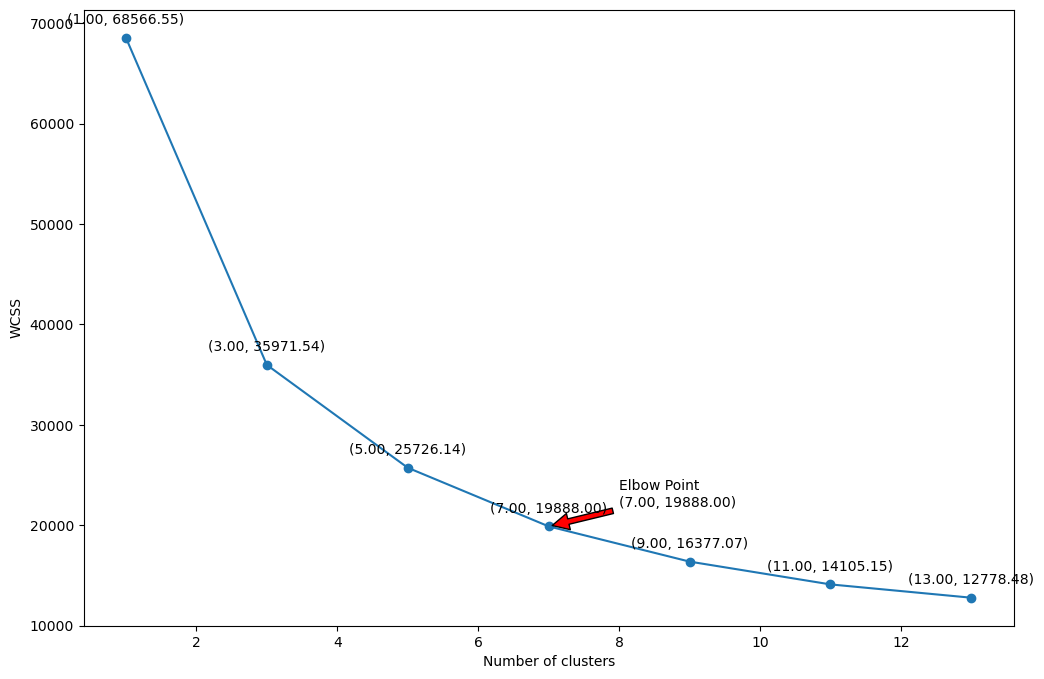

'The elbow point is not particularly clear in this plot. This is likely due to the data being more heterogenous (as can be seen in plots below) rather than very distinct clusters which tend to show a very clear turn in the profile. However, we can still choose a value and experimentation has shown that the results here do not significantly change with small changes in the chosen number.\n\nTherefore, in this case we select N=5 clusters.'

In [34]:
plt.figure(figsize=(12,8))
plt.plot(testing_range, wcss_score, marker = 'o')
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")

# Identify the elbow point
elbow_index = 3
elbow_point = (testing_range[elbow_index], wcss_score[elbow_index])

# Annotate the elbow point
elbow_text = f'Elbow Point\n({elbow_point[0]:.2f}, {elbow_point[1]:.2f})'
plt.annotate(elbow_text, xy=elbow_point, xytext=(elbow_point[0] + 1, elbow_point[1] + 2000),
             arrowprops=dict(facecolor='red', shrink=0.05))

# Annotate each marker with its coordinates
for i, txt in enumerate(zip(testing_range, wcss_score)):
    marker_text = f'({txt[0]:.2f}, {txt[1]:.2f})'
    plt.annotate(marker_text, (testing_range[i], wcss_score[i]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.show()

'''The elbow point is not particularly clear in this plot. This is likely due to the data being more heterogenous (as can be seen in plots below) rather than very distinct clusters which tend to show a very clear turn in the profile. However, we can still choose a value and experimentation has shown that the results here do not significantly change with small changes in the chosen number.

Therefore, in this case we select N=5 clusters.'''

In [35]:
#Rerun code with the selected number of clusters
n_clusters=5

kmeans = KMeans(n_clusters = n_clusters, init="k-means++", random_state=42)
kmeans.fit(X_scaled)

KMeans(n_clusters=5, random_state=42)

In [36]:
X_scaled['cluster_label'] = kmeans.labels_
X['cluster_label'] = kmeans.labels_

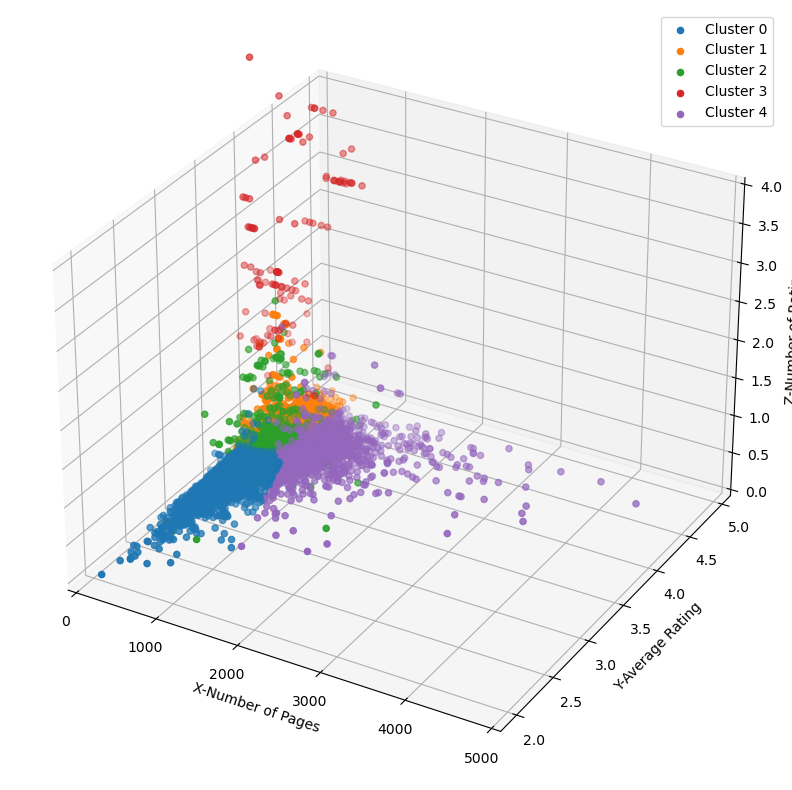

In [39]:
X_subset = X[['num_pages', 'avg_rating', 'num_ratings','cluster_label']]
X_subset = X_subset[:20000]
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot points coloured by cluster label
for cluster_label in range(n_clusters):
    cluster_data = X_subset[X_subset['cluster_label'] == cluster_label]
    ax.scatter(cluster_data['num_pages'], cluster_data['avg_rating'], cluster_data['num_ratings'], 
               label=f'Cluster {cluster_label}')

ax.set_xlabel('X-Number of Pages')
ax.set_ylabel('Y-Average Rating')
ax.set_zlabel('Z-Number of Ratings')
#ax.set_zscale("log")
ax.set_xlim(0,5000)
ax.set_zlim(0,4e6)
plt.legend();